## Dataset loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<br><br>

## Data preparation and exploration

In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
def make_bar_chart(column, title, ylabel, xlabel, y_offset=10, x_offset=0.2):
    ax = df.groupby(column).count()[['PassengerId']].plot(
        kind='bar', figsize=(10, 6), fontsize=13, color='#4f4f4f'
    )
    ax.set_title(title, size=20, pad=30)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.get_legend().remove()
                  
    for i in ax.patches:
        ax.text(i.get_x() + x_offset, i.get_height() + y_offset, i.get_height(), fontsize=20)
    return ax

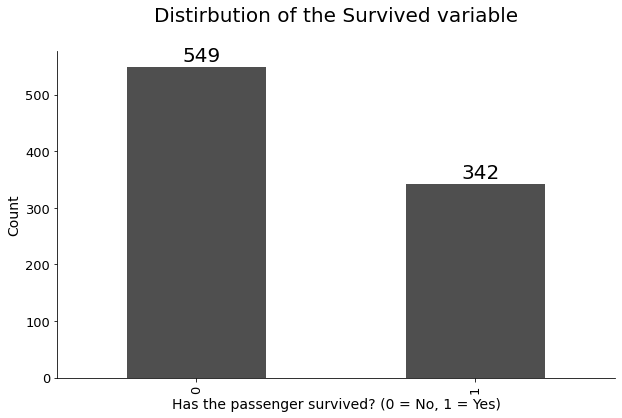

In [6]:
make_bar_chart(
    column='Survived',
    title='Distirbution of the Survived variable',
    ylabel='Count',
    xlabel='Has the passenger survived? (0 = No, 1 = Yes)'
);

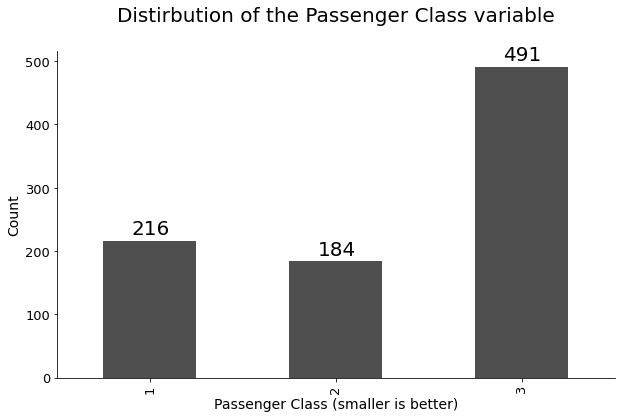

In [7]:
make_bar_chart(
    column='Pclass',
    title='Distirbution of the Passenger Class variable',
    ylabel='Count',
    xlabel='Passenger Class (smaller is better)',
    x_offset=0.15
);

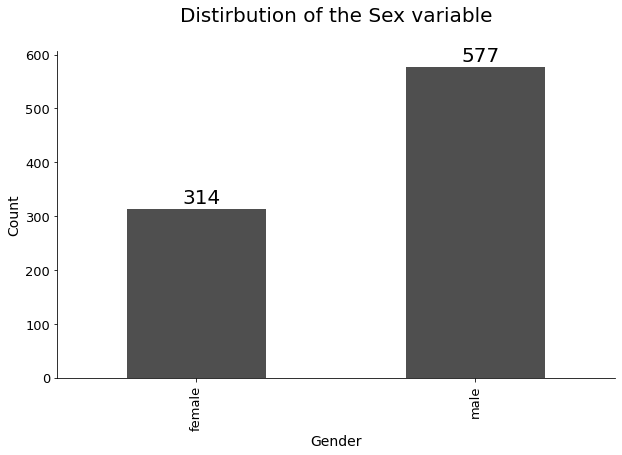

In [8]:
make_bar_chart(
    column='Sex',
    title='Distirbution of the Sex variable',
    ylabel='Count',
    xlabel='Gender'
);

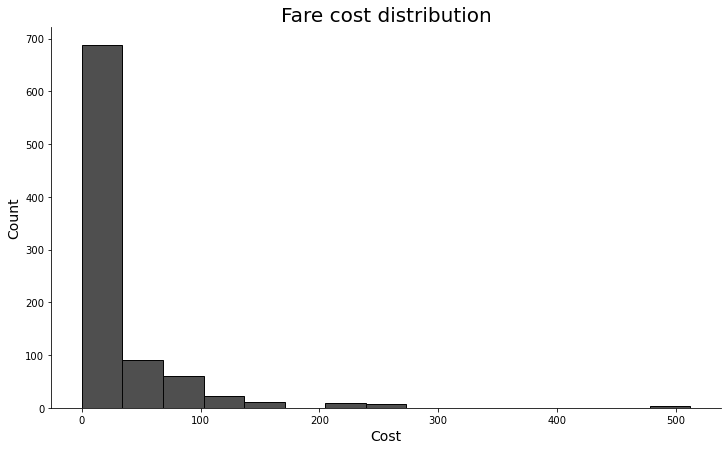

In [9]:
plt.figure(figsize=(12, 7))
plt.title('Fare cost distribution', size=20)
plt.xlabel('Cost', size=14)
plt.ylabel('Count', size=14)
plt.hist(df['Fare'], bins=15, color='#4f4f4f', ec='#040404');

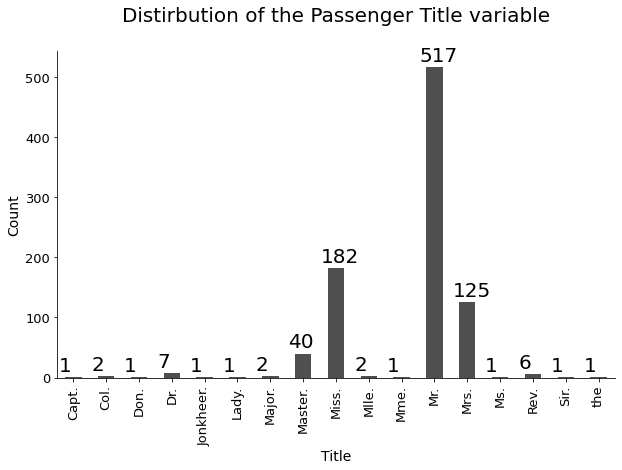

In [10]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])

make_bar_chart(
    column='Title',
    title='Distirbution of the Passenger Title variable',
    ylabel='Count',
    xlabel='Title',
    x_offset=-0.2
);

In [11]:
df.drop(['Ticket', 'PassengerId'], axis=1, inplace=True)

gender_mapper = {'male': 0, 'female': 1}
df['Sex'].replace(gender_mapper, inplace=True)

df['Title'] = [0 if x in ['Mr.', 'Miss.', 'Mrs.'] else 1 for x in df['Title']]
df = df.rename(columns={'Title': 'Title_Unusual'})
df.drop('Name', axis=1, inplace=True)

df['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in df['Cabin']]
df.drop('Cabin', axis=1, inplace=True)

emb_dummies = pd.get_dummies(df['Embarked'], drop_first=True, prefix='Embarked')
df = pd.concat([df, emb_dummies], axis=1)
df.drop('Embarked', axis=1, inplace=True)

df['Age'] = df['Age'].fillna(int(df['Age'].mean()))

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,0,1


<br><br>

## Modeling

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

y_train.shape, y_test.shape

((668,), (223,))

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

lm = LogisticRegression(random_state=42)
lm.fit(X_train, y_train)

lm_preds = lm.predict(X_test)
print(confusion_matrix(y_test, lm_preds))

[[111  23]
 [ 23  66]]


/Users/dradecic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
from sklearn.metrics import f1_score

print(f1_score(y_test, lm_preds))

0.7415730337078652


In [17]:
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(
    scoring='f1',
    max_time_mins=10,
    random_state=42,
    verbosity=2
)

pipeline_optimizer.fit(X_train, y_train)

/Users/dradecic/opt/anaconda3/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.7668883546121398

Generation 2 - Current best internal CV score: 0.7668883546121398

Generation 3 - Current best internal CV score: 0.7668883546121398

Generation 4 - Current best internal CV score: 0.7706865623331014

Generation 5 - Current best internal CV score: 0.7780316553709037

Generation 6 - Current best internal CV score: 0.7780316553709037

Generation 7 - Current best internal CV score: 0.7780316553709037

10.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.5)


TPOTClassifier(max_time_mins=10, random_state=42, scoring='f1', verbosity=2)

In [19]:
pipeline_optimizer.score(X_test, y_test)

0.7701149425287356

In [22]:
tpot_preds = pipeline_optimizer.predict(X_test)

from sklearn.metrics import accuracy_score

print(f'Baseline model accuracy: {accuracy_score(y_test, lm_preds)}')
print(f'TPOT model accuracy: {accuracy_score(y_test, tpot_preds)}')

Baseline model accuracy: 0.7937219730941704
TPOT model accuracy: 0.820627802690583


In [20]:
pipeline_optimizer.fitted_pipeline_

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7fef9d7ba8b0>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7fef9d7ba8b0>))])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree...id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               

In [21]:
pipeline_optimizer.export('titanic_pipeline.py')